# Carbon Use Efficiency of Marine Heterotrophs

In [2]:
import cobra
import os
import pandas as pd

In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Local install of gem2cue
# Should only need to be run once
# !python -m pip install -e /home/helen/Documents/PhD/Segre\ Lab/GEM2CUE

In [5]:
import gem2cue.utils

## Set-up

In [6]:
# Read in the meta-data file as a data frame
meta_df = pd.read_csv('IAMM_models/strain_metadata.tsv', sep='\t')
meta_df

,strain,model_file,gc_content,genome_length,memote_score,purely_met_rxns
0,Bork,Bork-LB.xml,0.547278,3120143,0.87,0.6515
1,Dies,Dies-LB.xml,0.616316,4928223,0.70,0.5889
2,Hot1A3,Hot1A3-LB.xml,0.446714,4801807,0.71,0.5993
3,BS11,BS11-LB.xml,0.446078,4480507,0.71,0.6106
4,DE,DE-LB.xml,0.448687,4480937,0.70,0.6163
5,Cstat,Cstat-LB.xml,0.548907,2862233,0.71,0.5887
6,DFL12,DFL12-LB.xml,0.655246,4417868,0.71,0.6266
7,Kuro,Kuro-LB.xml,0.470156,3850372,0.87,0.6224
8,HP15,HP15-LB.xml,0.568599,4651725,0.87,0.6182
9,MMB1,MMB1-LB.xml,0.441275,4684316,0.70,0.5675


In [7]:
# For each row, make a Strain object with the model and metadata from the table
strain_list = []
for index, row in meta_df.iterrows():
    strain_list.append(gem2cue.utils.Strain(row['strain'],
                                            cobra.io.read_sbml_model(os.path.join('IAMM_models', 'models', row['model_file'])),
                                            {'GC Content': row['gc_content'],
                                            'Genome Length': row['genome_length'],
                                            'Memote Score': row['memote_score'],
                                            'Purely Metabolic Rxns': row['purely_met_rxns']}))

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


## Constrain the model to relevant biomass production levels
MEMOTE says that the max biomass flux should be < 3.

In [8]:
# Make an experiment for each Strain and run it to get a list of the biomasses using the unconstrained media
unconstrained_experiments = [gem2cue.utils.Experiment(strain) for strain in strain_list]
for exp in unconstrained_experiments:
	exp.run()
[exp.solution.objective_value for exp in unconstrained_experiments]

[36.954098423659175,
 68.98783902595073,
 59.368199045920605,
 51.42814575046219,
 51.26800822967742,
 52.699138347259044,
 73.77761996254044,
 40.9490890286503,
 60.49274956804522,
 59.95926016674317,
 77.57976294839148,
 69.1591618725659,
 38.00516887469422,
 43.8387121854178,
 40.18871103011229,
 59.88795528224471,
 41.69272044767435,
 101.94667602650313,
 67.98498571419445,
 67.03983159862463]

In [9]:
glc_10_media = gem2cue.utils.Media({
 'EX_aso3_e': 1000.0,
 'EX_aso4_e': 1000.0,
 'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 10.0, # Glucose
 'EX_glc__aD_e': 10.0, # Alpha glucose
 'EX_h2_e': 1000.0,
 'EX_h2o2_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_h2s_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_no2_e': 1000.0,
 'EX_no3_e': 1000.0,
 'EX_no_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_ppi_e': 1000.0, # Diphosphate
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so3_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tsul_e': 1000.0,
 'EX_zn2_e': 1000.0})

In [10]:
# Make an experiment for each Strain
glucose_experiments = [gem2cue.utils.Experiment(strain, media=glc_10_media) for strain in strain_list]

In [11]:
# Run it and look at the biomasses again
for exp in glucose_experiments:
	exp.run()
[exp.solution.objective_value for exp in glucose_experiments]

[1.462269570077639,
 1.462276698106202,
 1.4622695699736659,
 3.638705778613612e-15,
 1.227841600227896e-27,
 0.7404944029359897,
 1.4622695703166104,
 -3.617011689028021e-28,
 2.9245391401544554,
 0.9722306594724321,
 2.724111365077684,
 1.4623323298893431,
 -1.3934894477665777e-14,
 0.8674985310087885,
 2.9246646597789154,
 0.9555090524158861,
 1.4621945932424791,
 2.92455339510745,
 1.4622695700747885,
 1.4622766975531185]

## Analysis

#### Glucose CUE vs Metadata

In [12]:
# Calculate CUE for all of the Experiments
for exp in glucose_experiments:
    exp.CUE(ex_nomenclature = {'C_e'})

##### CUE vs GC content

In [13]:
cue_vals = [exp.cue for exp in glucose_experiments if exp.cue is not None]
gc_vals = [exp.strain.metadata['GC Content'] for exp in glucose_experiments if exp.cue is not None]
len_vals = [exp.strain.metadata['Genome Length'] for exp in glucose_experiments if exp.cue is not None]
rxn_vals = [exp.strain.metadata['Purely Metabolic Rxns'] for exp in glucose_experiments if exp.cue is not None]


In [17]:
cue_vals

[1.0,
 1.0,
 1.0,
 1.0325074129013956e-14,
 2.2215562722749382e-13,
 0.47925390153527103,
 1.0,
 -8.659739592076221e-15,
 1.0,
 0.6649188536582247,
 0.931466885730637,
 1.0,
 -1.1102230246251565e-14,
 0.2807223800513512,
 1.0,
 0.6534712554590996,
 1.0,
 1.0,
 1.0,
 1.0]

/home/helen/miniconda3/envs/GRC/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


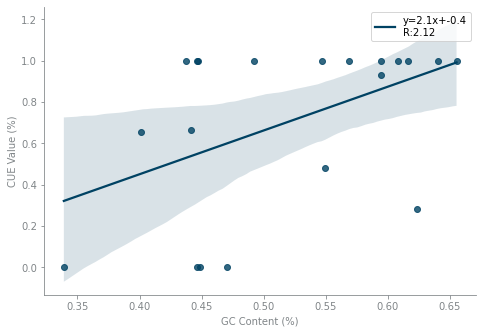

In [14]:
# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(gc_vals, cue_vals)

# use line_kws to set line label for legend
ax = sns.regplot(gc_vals, cue_vals, color='#004263',
	line_kws={'label':"y={0:.1f}x+{1:.1f}\nR:{0:.2f}".format(slope,intercept, r_value)})

# plot legend
ax.legend()

# Style
# rcParams.update({'font.size': 40})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('#818689')
ax.yaxis.label.set_color('#818689')
ax.tick_params(axis='y', colors='#818689')

ax.spines['bottom'].set_color('#818689')
ax.xaxis.label.set_color('#818689')
ax.tick_params(axis='x', colors='#818689')

# Labels
plt.ylabel('CUE Value (%)')
plt.xlabel('GC Content (%)')

# # Show
# fig.set_size_inches(18.5, 10.5)
plt.show()

##### CUE vs Genome Length

/home/helen/miniconda3/envs/GRC/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


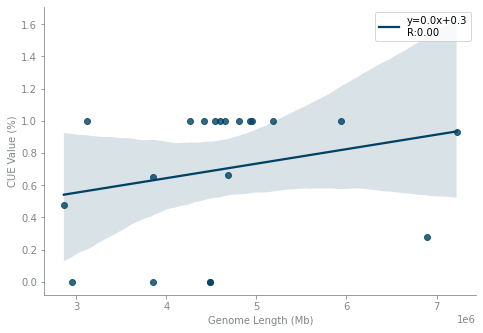

In [15]:
# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(len_vals, cue_vals)

# use line_kws to set line label for legend
ax = sns.regplot(len_vals, cue_vals, color='#004263',
	line_kws={'label':"y={0:.1f}x+{1:.1f}\nR:{0:.2f}".format(slope,intercept, r_value)})

# plot legend
ax.legend()

# Style
# rcParams.update({'font.size': 40})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('#818689')
ax.yaxis.label.set_color('#818689')
ax.tick_params(axis='y', colors='#818689')

ax.spines['bottom'].set_color('#818689')
ax.xaxis.label.set_color('#818689')
ax.tick_params(axis='x', colors='#818689')

# Labels
plt.ylabel('CUE Value (%)')
plt.xlabel('Genome Length (Mb)')

# # Show
# fig.set_size_inches(18.5, 10.5)
plt.show()

##### CUE vs % of Purely Metabolic Reactions

/home/helen/miniconda3/envs/GRC/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


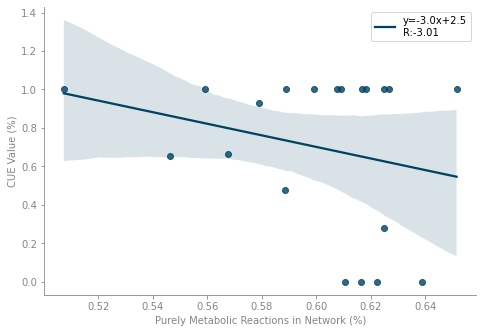

In [16]:
# Create a figure instance
fig = plt.figure()

# Create an axes instance
ax = fig.add_axes([0,0,1,1])

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(rxn_vals, cue_vals)

# use line_kws to set line label for legend
ax = sns.regplot(rxn_vals, cue_vals, color='#004263',
	line_kws={'label':"y={0:.1f}x+{1:.1f}\nR:{0:.2f}".format(slope,intercept, r_value)})

# plot legend
ax.legend()

# Style
# rcParams.update({'font.size': 40})

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('#818689')
ax.yaxis.label.set_color('#818689')
ax.tick_params(axis='y', colors='#818689')

ax.spines['bottom'].set_color('#818689')
ax.xaxis.label.set_color('#818689')
ax.tick_params(axis='x', colors='#818689')

# Labels
plt.ylabel('CUE Value (%)')
plt.xlabel('Purely Metabolic Reactions in Network (%)')

# # Show
# fig.set_size_inches(18.5, 10.5)
plt.show()